In [44]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
def read_glove_file(filename = 'glove.6B.50d.txt'):
    with open(filename, 'r') as f:
        words = set()
        words_to_vec_map = dict()
        for line in f:
            # Remove extra white spaces and split the line
            li = line.strip().split()
            words.add(li[0])
            words_to_vec_map[li[0]] = np.array(li[1:], dtype=np.float64)
    idx_to_words = dict()
    words_to_idx = dict()
    i = 1
    for word in sorted(words):
        words_to_idx[word] = i
        idx_to_words[i] = word
        i += 1
    return words_to_vec_map, words_to_idx, idx_to_words

words_to_vec_map, words_to_idx, idx_to_words = read_glove_file()
label_to_idx = {'Irrelevant': 0, 'Negative': 1, 'Neutral': 0, 'Positive': 2}

In [15]:
def preprocess_text(txt):
    review = re.sub('[^a-zA-Z]', ' ', txt)
    review = review.lower()
    review = review.split()

    review = [word for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review
def sentence_to_indices(X, words_to_idx ,maxLen):
    m = X.shape[0]
    X_out = np.zeros((m, maxLen))
    for i in range(m):
        li = X[i].lower().strip().split()
        j = 0
        for w in li:
            if (j >= maxLen): break
            if w in words_to_idx.keys():
                X_out[i,j] = words_to_idx[w]
            j += 1
    return X_out

In [5]:
model = load_model('model_one_hot_preprocess.h5')

2023-12-19 11:40:41.312289: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
def predict_for_sentence(sentence, model, words_to_idx = words_to_idx, maxLen = 64):
    sentence_preprocessed = preprocess_text(sentence)
    sentence_indices = sentence_to_indices(np.array([sentence_preprocessed]), words_to_idx, maxLen)
    pred = model.predict(sentence_indices)[0]
    print(f"Negative: {pred[1]}")
    print(f"Neutral: {pred[0]}")
    print(f"Positive: {pred[2]}")
    return

In [27]:
test_example = "Can you bring me some coffee"
pred = predict_for_sentence(test_example, model)
print(pred)

1/1 [==============================] - 0s 28ms/step


Negative: 0.11062783747911453
Neutral: 0.3946632146835327
Positive: 0.49470892548561096
None


In [32]:
def load_data(label_to_idx, csv_file = 'data/twitter_training.csv'):
    df = pd.read_csv(csv_file, header=None)
    df = df.dropna()
    data = set()
    for _, row in tqdm(df.iterrows(), total = len(df)):
        if (row[2]=="Irrelevant"): continue
        txt = row[3]
        txt = preprocess_text(txt)
        data.add((txt, label_to_idx[row[2]]))
    data = list(data)
    X = np.asarray([tup[0] for tup in data])
    y = np.asarray([tup[1] for tup in data], dtype=int)
    return X, y

def convert_to_one_hot(y, C = 3):
    return np.eye(C)[y.reshape(-1)]

In [31]:
X_val, y_val = load_data(label_to_idx, csv_file='data/twitter_validation.csv')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1031.92it/s]


In [33]:
X_val_indices = sentence_to_indices(X_val, words_to_idx, 64)
y_val_oh = convert_to_one_hot(y_val)

In [37]:
y_val_pred = model.predict(X_val_indices)
y_val_pred_indices = y_val_pred.argmax(axis = 1)

26/26 [==============================] - 1s 42ms/step


In [48]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

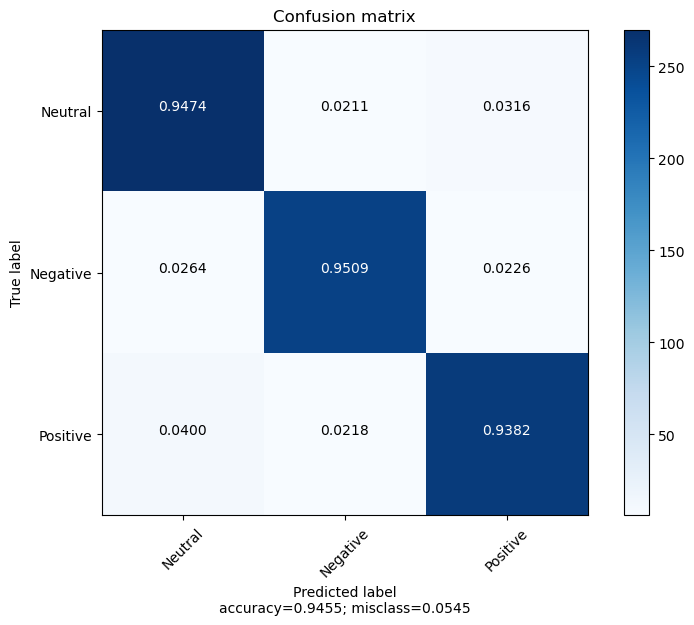

In [49]:
labels_arr = np.array([0, 1, 2])
cm = confusion_matrix(y_true=y_val, y_pred=y_val_pred_indices, labels=labels_arr)
plot_confusion_matrix(cm, target_names=['Neutral', 'Negative', 'Positive'])

In [47]:
import os
model_save_name = "model_one_hot_preprocess.h5"
os.path.isfile(model_save_name)

True